# State-of-the-art model composition in MLJ (Machine Learning in Julia)

In this script we use model stacking to demonstrate the ease with
which machine learning models can be combined in sophisticated ways
using MLJ. In practice, one would use MLJ's [canned stacking model
constructor](https://alan-turing-institute.github.io/MLJ.jl/dev/model_stacking/#Model-Stacking)
`Stack`. Here, however, we give a quick demonstation how you would
build a stack yourself, using MLJ's generic model composition
syntax, which is an extension of the normal fit/predict syntax.

For a more leisurely notebook on the same material, see
[this](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/stacking/)
tutorial.

In [1]:
DIR = @__DIR__
include(joinpath(DIR, "setup.jl"))

  Activating environment at `~/Google Drive/Julia/MLJ/MachineLearningInJulia2020/Project.toml`
[ Info: Done loading


## Stacking is hard

[Model
stacking](https://alan-turing-institute.github.io/DataScienceTutorials.jl/getting-started/stacking/),
popular in Kaggle data science competitions, is a sophisticated way
to blend the predictions of multiple models.

With the python toolbox
[scikit-learn](https://scikit-learn.org/stable/) (or its [julia
wrap](https://github.com/cstjean/ScikitLearn.jl)) you can use
pipelines to combine composite models in simple ways but (automated)
stacking is beyond its capabilities.

One python alternative is to use
[vecstack](https://github.com/vecxoz/vecstack). The [core
algorithm](https://github.com/vecxoz/vecstack/blob/master/vecstack/core.py)
is about eight pages (without the scikit-learn interface):

![](vecstack.png).

## Stacking is easy (in MLJ)

Using MLJ's [generic model composition
API](https://alan-turing-institute.github.io/MLJ.jl/dev/composing_models/)
you can build a stack in about a page.

Here's the complete code needed to define a new model type that
stacks two base regressors and one adjudicator in MLJ.  Here we use
three folds to create the base-learner [out-of-sample
predictions](https://alan-turing-institute.github.io/DataScienceTutorials.jl/getting-started/stacking/)
to make it easier to read. You can make this generic with little fuss.

In [2]:
using MLJ

folds(data, nfolds) =
    partition(1:nrows(data), (1/nfolds for i in 1:(nfolds-1))...);

these models are only going to be default choices for the stack:

In [3]:
LinearRegressor = @load LinearRegressor pkg=MLJLinearModels
model1 = LinearRegressor()
model2 = LinearRegressor()
judge = LinearRegressor()

X = source()
y = source()

folds(X::AbstractNode, nfolds) = node(XX->folds(XX, nfolds), X)
MLJ.restrict(X::AbstractNode, f::AbstractNode, i) =
    node((XX, ff) -> restrict(XX, ff, i), X, f);
MLJ.corestrict(X::AbstractNode, f::AbstractNode, i) =
    node((XX, ff) -> corestrict(XX, ff, i), X, f);

f = folds(X, 3)

m11 = machine(model1, corestrict(X, f, 1), corestrict(y, f, 1))
m12 = machine(model1, corestrict(X, f, 2), corestrict(y, f, 2))
m13 = machine(model1, corestrict(X, f, 3), corestrict(y, f, 3))

y11 = predict(m11, restrict(X, f, 1));
y12 = predict(m12, restrict(X, f, 2));
y13 = predict(m13, restrict(X, f, 3));

m21 = machine(model2, corestrict(X, f, 1), corestrict(y, f, 1))
m22 = machine(model2, corestrict(X, f, 2), corestrict(y, f, 2))
m23 = machine(model2, corestrict(X, f, 3), corestrict(y, f, 3))

y21 = predict(m21, restrict(X, f, 1));
y22 = predict(m22, restrict(X, f, 2));
y23 = predict(m23, restrict(X, f, 3));

y1_oos = vcat(y11, y12, y13);
y2_oos = vcat(y21, y22, y23);

X_oos = MLJ.table(hcat(y1_oos, y2_oos))

m_judge = machine(judge, X_oos, y)

m1 = machine(model1, X, y)
m2 = machine(model2, X, y)

y1 = predict(m1, X);
y2 = predict(m2, X);

X_judge = MLJ.table(hcat(y1, y2))
yhat = predict(m_judge, X_judge)

@from_network machine(Deterministic(), X, y; predict=yhat) begin
    mutable struct MyStack
        regressor1=model1
        regressor2=model2
        judge=judge
    end
end

my_stack = MyStack()

[ Info: For silent loading, specify `verbosity=0`. 
import MLJLinearModels ✔


MyStack(
    regressor1 = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    regressor2 = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    judge = LinearRegressor(
            fit_intercept = true,
            solver = nothing))

For the curious: Only the last block defines the new model type. The
rest defines a *[learning network]()* - a kind of working prototype
or blueprint for the type. If the source nodes `X` and `y` wrap some
data (instead of nothing) then the network can be trained and tested
as you build it.

## Composition plays well with other work-flows

We did not include standardization of inputs and target (with
post-prediction inversion) in our stack. However, we can add these
now, using MLJ's canned pipeline composition:

In [4]:
pipe = @pipeline Standardizer my_stack target=Standardizer

┌ Info: Treating pipeline as a `Deterministic` predictor.
└ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 


Pipeline316(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    my_stack = MyStack(
            regressor1 = LinearRegressor,
            regressor2 = LinearRegressor,
            judge = LinearRegressor),
    target = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false))

Want to change a base learner and adjudicator?

In [5]:
DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree;
KNNRegressor = @load KNNRegressor;
pipe.my_stack.regressor2 = DecisionTreeRegressor()
pipe.my_stack.judge = KNNRegressor();

[ Info: For silent loading, specify `verbosity=0`. 
import MLJDecisionTreeInterface ✔
[ Info: For silent loading, specify `verbosity=0`. 
import NearestNeighborModels ✔


Want a CV estimate of performance of the complete model on some data?

In [6]:
X, y = @load_boston;
mach = machine(pipe, X, y)
evaluate!(mach, resampling=CV(), measure=mae)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:03


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────┬─────────────┬───────────┬──────────────────────────────────────┐
│ measure             │ measurement │ operation │ per_fold                             │
├─────────────────────┼─────────────┼───────────┼──────────────────────────────────────┤
│ MeanAbsoluteError() │ 4.08        │ predict   │ [3.51, 3.32, 3.57, 3.55, 6.39, 4.13] │
└─────────────────────┴─────────────┴───────────┴──────────────────────────────────────┘


Want to inspect the learned parameters of the adjudicator?

In [7]:
fp =  fitted_params(mach);
fp.my_stack.judge

(tree = NearestNeighbors.KDTree{StaticArrays.SVector{2, Float64}, Distances.Euclidean, Float64}
  Number of points: 422
  Dimensions: 2
  Metric: Distances.Euclidean(0.0)
  Reordered: true,)

What about the first base-learner of the stack? There are four sets
of learned parameters!  One for each fold to make an out-of-sample
prediction, and one trained on all the data:

In [8]:
fp.my_stack.regressor1

4-element Vector{NamedTuple{(:coefs, :intercept), Tuple{Vector{Pair{Symbol, Float64}}, Float64}}}:
 (coefs = [:Crim => -0.14989998505050764, :Zn => 0.12451030725934338, :Indus => 0.045723152402140074, :NOx => -0.20952000821515018, :Rm => 0.3338868272921799, :Age => 0.03102642905288964, :Dis => -0.32010092389552863, :Rad => 0.36244871669752154, :Tax => -0.25586500602060663, :PTRatio => -0.212382845225511, :Black => 0.010390650033101637, :LStat => -0.4295189896332337], intercept = -2.5091739277862327e-16)
 (coefs = [:Crim => -0.15264857459778866, :Zn => 0.16933996101212626, :Indus => 0.09817393701370102, :NOx => -0.29150172536336916, :Rm => 0.2903559758910672, :Age => 0.04933337270371607, :Dis => -0.4223092758606594, :Rad => 0.29115481204819815, :Tax => -0.22197931055356784, :PTRatio => -0.1877887553695512, :Black => 0.013283327549796968, :LStat => -0.4851160536910277], intercept = 0.047984736385374385)
 (coefs = [:Crim => -0.14920933046037113, :Zn => 0.11006472686762443, :Indus => 0.079

In [9]:
fp.my_stack.regressor1[1].coefs

12-element Vector{Pair{Symbol, Float64}}:
    :Crim => -0.14989998505050764
      :Zn => 0.12451030725934338
   :Indus => 0.045723152402140074
     :NOx => -0.20952000821515018
      :Rm => 0.3338868272921799
     :Age => 0.03102642905288964
     :Dis => -0.32010092389552863
     :Rad => 0.36244871669752154
     :Tax => -0.25586500602060663
 :PTRatio => -0.212382845225511
   :Black => 0.010390650033101637
   :LStat => -0.4295189896332337

Want to tune multiple (nested) hyperparameters in the stack? Tuning is a
model wrapper (for better composition!):

In [10]:
r1 = range(pipe, :(my_stack.regressor2.max_depth), lower = 1, upper = 25, scale=:linear)
r2 = range(pipe, :(my_stack.judge.K), lower=1, origin=10, unit=10, scale=:log10)

import Distributions.Poisson

tuned_pipe = TunedModel(model=pipe,
                         ranges=[r1, (r2, Poisson)],
                         tuning=RandomSearch(),
                         resampling=CV(),
                         measure=rms,
                         n=100)
mach = machine(tuned_pipe, X, y) |> fit!
best_model = fitted_params(mach).best_model
K = fitted_params(mach).best_model.my_stack.judge.K;
max_depth = fitted_params(mach).best_model.my_stack.regressor2.max_depth
@show K max_depth;

[ Info: Training Machine{DeterministicTunedModel{RandomSearch,…},…}.
[ Info: Attempting to evaluate 100 models.
Evaluating over 100 metamodels: 100%[=========================] Time: 0:00:10
K = 18
max_depth = 21


Visualize tuning results:

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


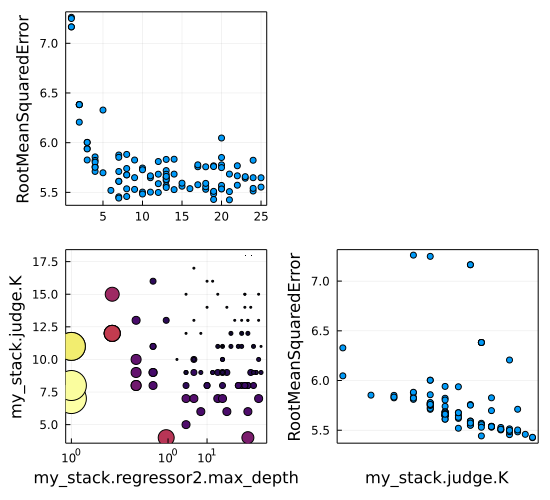

In [11]:
using Plots
gr(size=(700,700*(sqrt(5) - 1)/2))
plt = plot(mach)
savefig("stacking.png")
plt

![](stacking.png)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*